In [519]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import random
import matplotlib.colors as mcolors
from einops import rearrange

In [520]:
def create_colormap(n):
    hsv_colors = [(i / n, 0.75, 0.75) for i in range(n)]
    random.Random(1337).shuffle(hsv_colors)
    rgb_colors = [mcolors.hsv_to_rgb(hsv) for hsv in hsv_colors]
    color_map = torch.tensor((np.array(rgb_colors) * 255).astype(np.uint8))

    return color_map

In [521]:
def color_patch(im, position, patch_size):
    color_map = create_colormap(patch_size ** 2)
    counter = 0
    for i in range(patch_size):
        for j in range(patch_size):
            pos = (position[0] + i, position[1] + j)
            im[pos[1], pos[0], : ] = color_map[counter]
            counter += 1
            

In [522]:
def show_image(im, position, patch_size):
    plt.figure()
    x_offset = patch_size
    y_offset = patch_size
    plt.imshow(im[position[1] - y_offset:position[1] + y_offset*2, position[0] - x_offset:position[0] + x_offset*2, :])
    

In [523]:
def get_2dpos_of_curr_ps_in_min_ps(height, width, patch_size, min_patch_size):
    patches_coords = torch.meshgrid(torch.arange(0, width // min_patch_size, patch_size // min_patch_size), torch.arange(0, height // min_patch_size, patch_size // min_patch_size), indexing='ij')
    patches_coords = torch.stack([patches_coords[0], patches_coords[1]])
    patches_coords = patches_coords.permute(1, 2, 0)
    patches_coords = patches_coords.transpose(0, 1)
    patches_coords = patches_coords.reshape(-1, 2)
    return patches_coords

In [524]:
def add_high_res_feat(tokens, pos, im, min_patch_size, patch_size):
    b, n, _ = pos.shape
    pos_org = pos.clone() * min_patch_size
    patch_coords = torch.stack(torch.meshgrid(torch.arange(0, patch_size), torch.arange(0, patch_size)))
    patch_coords = patch_coords.permute(1, 2, 0).transpose(0, 1).reshape(-1, 2).to(pos.device)
    patch_coords = patch_coords.repeat(b, 1, 1)
    pos_patches = pos_org.unsqueeze(2) + patch_coords.unsqueeze(1)
    pos_patches = pos_patches.view(b, -1, 2)
    x_pos = pos_patches[..., 0].long()
    y_pos = pos_patches[..., 1].long()
    b_ = torch.arange(b).unsqueeze(-1).expand(-1, pos_patches.shape[1])
    im_high = im[b_, :, y_pos, x_pos]
    im_high = rearrange(im_high, 'b (n p) c -> b n (p c)', b=b, n=n, c=3)
    tokens = tokens + im_high

    return tokens

In [525]:
def split_pos(pos_to_split, curr_scale):
    batch_size = pos_to_split.shape[0]
    new_coord_ratio = 2 ** (4 - curr_scale - 1)
    a = torch.stack([pos_to_split[:, :, 0], pos_to_split[:, :, 1]], dim=2)
    b = torch.stack([pos_to_split[:, :, 0] + new_coord_ratio, pos_to_split[:, :, 1]], dim=2)
    c = torch.stack([pos_to_split[:, :, 0], pos_to_split[:, :, 1] + new_coord_ratio], dim=2)
    d = torch.stack([pos_to_split[:, :, 0] + new_coord_ratio, pos_to_split[:, :, 1] + new_coord_ratio], dim=2)

    new_pos_2dim = torch.stack([a, b, c, d], dim=2)
    new_pos_2dim = rearrange(new_pos_2dim, 'b n s c -> b (n s) c', s=4, c=2).contiguous()
    new_pos_2dim = new_pos_2dim.repeat(batch_size, 1, 1)

    return new_pos_2dim

In [526]:
def rgb_im_from_feat_pos(feat, pos, patch_size, height, width, min_patch_size):
    rgb_im = torch.zeros(height, width, 3)
    pos = pos * min_patch_size
    for f, p in zip(feat.squeeze(), pos.squeeze()):
        f_patch = rearrange(f, '(ph pw c) -> ph pw c', ph=patch_size, pw=patch_size, c=3)
        rgb_im[p[1]:p[1] + patch_size, p[0]:p[0] +patch_size, :] = f_patch
    return rgb_im
    

torch.Size([1, 1280, 48])


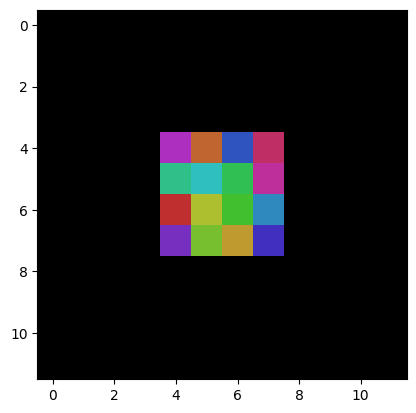

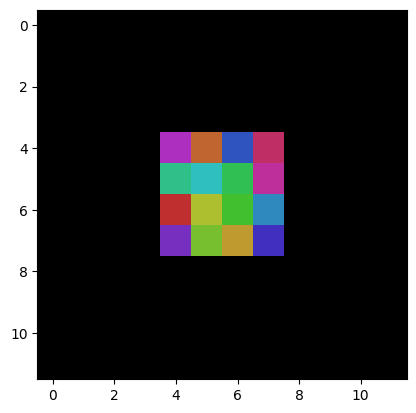

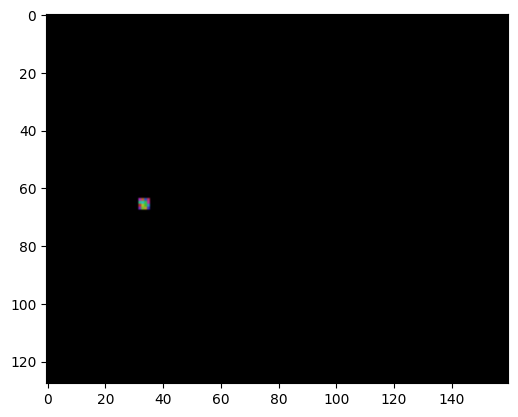

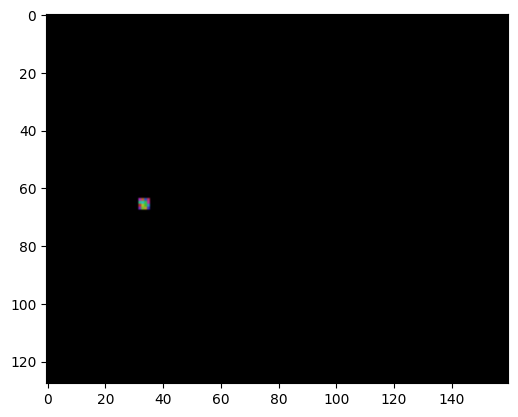

In [527]:
height = 128
width = 160
batch_size = 1

im = torch.zeros(height, width, 3).int()

position_to_test = (32,64)
patch_size = 4
min_patch_size = 4

color_patch(im, position_to_test, patch_size)
show_image(im, position_to_test, patch_size)


org_patch_size = 32

n_feats = (height // patch_size) *  (width // patch_size)
feat_dim = 3  * patch_size**2
feat = torch.zeros(batch_size, n_feats, feat_dim)
all_positions = get_2dpos_of_curr_ps_in_min_ps(height, width, org_patch_size, min_patch_size)
all_positions = all_positions.unsqueeze(0)
scale = 1
all_positions = split_pos(all_positions, scale)
scale = 2
all_positions = split_pos(all_positions, scale)
scale = 3
all_positions = split_pos(all_positions, scale)

print(feat.shape)
all_positions = all_positions[:,640:1000,:]
feat = feat[:,640:1000,:]

im = im.permute(2,0,1).unsqueeze(0)

direct_pos = get_2dpos_of_curr_ps_in_min_ps(height, width, patch_size, min_patch_size).unsqueeze(0)

feat = add_high_res_feat(feat, all_positions, im, min_patch_size, patch_size)
feat_im = rgb_im_from_feat_pos(feat, all_positions, patch_size, height, width, min_patch_size)
show_image(feat_im.squeeze().int(), position_to_test, patch_size)

plt.figure()
plt.imshow(feat_im.squeeze().int())

plt.figure()
plt.imshow(im.squeeze().permute(1,2,0))

